In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import RandomOverSampler

import seaborn as sns


In [2]:
df = pd.read_csv('Articles Dataset.csv')

In [6]:
df.head()

,Unnamed: 0,article,link,title,genre
0,0,ڪراچي(ويب ڊيسڪ)قومي ڪرڪيٽ ٽيم جو اڳوڻو ناليوا...,https://awamiawaz.pk/752736/,\n\t\t\t\tشاهد آفريدي ڪي پي ايل ۾ جوهر ڏيکارڻ ...,sports
1,1,ممبئي(ويب ڊيسڪ)انگلينڊ پاڪستان جا سڀ ٿورا وسا...,https://awamiawaz.pk/752734/,\n\t\t\t\tانگلينڊ پاڪستان جا سڀ ٿورا وساري ڇڏي...,sports
2,2,.ٽوڪيو (ويب ڊيسڪ)ٽوڪيو اولمپڪس ۾ وڌيڪ ٽن راند...,https://awamiawaz.pk/752357/,\n\t\t\t\tٽوڪيو اولمپڪس مان پاڪستان جي وڌيڪ ٽن...,sports
3,3,اسلام آباد(ويب ڊيسڪ) سڌُ سماءَ واري وفاقي وزي...,https://awamiawaz.pk/752332/,\n\t\t\t\tڀارت راند کي سياست ۾ آڻي پنهنجو خراب...,sports
4,4,\nڪراچي(ويب ڊيسڪ) ڪشمير پريميئر ليگ (ڪي پي اي...,https://awamiawaz.pk/752284/,\n\t\t\t\tڪشمير پريميئر ليگ جي شيڊول جو اعلان ...,sports


In [7]:
# df['title']
title=[]
for i in range(0,3366):
    review = df['title'][i]
    review=review.split()
    review=' '.join(review)
    title.append(review)

In [8]:
df['genre'].unique()

array(['sports', 'entertainment', 'technology'], dtype=object)

In [9]:
df['genre'].value_counts()

sports           1457
entertainment    1214
technology        695
Name: genre, dtype: int64

In [10]:
title[9]

'ويسٽ انڊيز خلاف سيريز: بابر اعظم تبديلين جو اشارو ڏئي ڇڏيو'

In [11]:
x = title
y = df['genre']

In [12]:
y = LabelEncoder().fit_transform(y)

In [13]:
y

array([1, 1, 1, ..., 2, 2, 2])

In [14]:
x[1]

'انگلينڊ پاڪستان جا سڀ ٿورا وساري ڇڏيا'

In [15]:
cv = CountVectorizer()
x_cv = cv.fit_transform(x).toarray()

In [16]:
x_cv.shape

(3366, 5020)

In [17]:
from keras.models import Sequential
from keras import layers
# from keras.optimizers import RMSprop,Adam
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D



# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6947 unique tokens.


In [19]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['title'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3366, 250)


In [20]:
Y = pd.get_dummies(df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3366, 3)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3029, 250) (3029, 3)
(337, 250) (337, 3)


In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import EarlyStopping
epochs = 5
batch_size = 16
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
171/171 [==============================] - 431s 3s/step - loss: 0.7486 - accuracy: 0.6533 - val_loss: 0.2621 - val_accuracy: 0.9010
Epoch 2/5
171/171 [==============================] - 395s 2s/step - loss: 0.1425 - accuracy: 0.9593 - val_loss: 0.1828 - val_accuracy: 0.9274
Epoch 3/5
171/171 [==============================] - 334s 2s/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.1960 - val_accuracy: 0.9274
Epoch 4/5
171/171 [==============================] - 359s 2s/step - loss: 0.0137 - accuracy: 0.9978 - val_loss: 0.2610 - val_accuracy: 0.9142
Epoch 5/5
171/171 [==============================] - 341s 2s/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.2287 - val_accuracy: 0.9274


In [24]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 2s 156ms/step - loss: 0.1803 - accuracy: 0.9407
Test set
  Loss: 0.180
  Accuracy: 0.941


In [25]:
new_desc = ['ويسٽ انڊيز خلاف سيريز: بابر اعظم تبديلين جو اشارو ڏئي ڇڏيو']
seq = tokenizer.texts_to_sequences(new_desc)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['sports', 'entertainment', 'technology']
print(pred, labels[np.argmax(pred)])

[[1.8048439e-04 9.9980372e-01 1.5901745e-05]] entertainment


In [60]:
x_train, x_test, y_train, y_test = train_test_split(x_cv,y,test_size=0.20, random_state=0)
lr = LogisticRegression()
lr

In [63]:
model = lr.fit(x_train,y_train)
model.score(x_test,y_test)

0.9451038575667656

In [66]:
cm  = confusion_matrix(y_test,pred)
cm

array([[214,   9,   1],
       [ 13, 286,   2],
       [  9,   3, 137]], dtype=int64)

<AxesSubplot:>

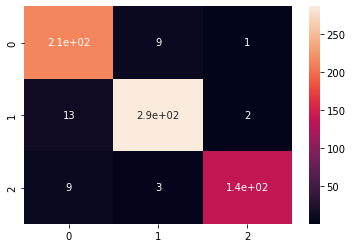

In [67]:
sns.heatmap(cm, annot=True)

In [26]:
tree = DecisionTreeClassifier()
model1 = tree.fit(x_train,y_train)

In [27]:
model1.score(x_test,y_test)

0.8664688427299704

In [28]:
tree_pred = tree.predict(x_test)
cm = confusion_matrix(y_test,tree_pred)
cm

array([[197,  16,  11],
       [ 29, 268,   4],
       [ 22,   8, 119]], dtype=int64)

<AxesSubplot:>

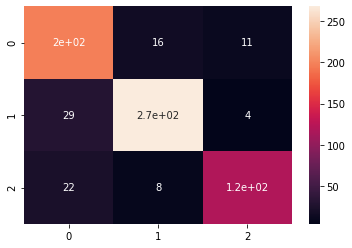

In [29]:
sns.heatmap(cm, annot=True)

In [34]:
rfc = RandomForestClassifier()
model2 = rfc.fit(x_train,y_train)

In [35]:
model2.score(x_test,y_test)

0.9020771513353115

In [37]:
dtree_pred = rfc.predict(x_test)
cm = confusion_matrix(y_test,dtree_pred)
cm

array([[213,   7,   4],
       [ 26, 275,   0],
       [ 23,   6, 120]], dtype=int64)

<AxesSubplot:>

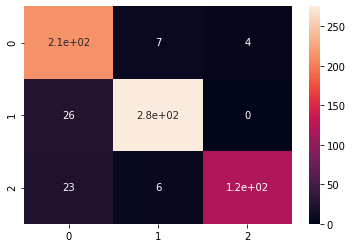

In [38]:
sns.heatmap(cm, annot=True)

In [39]:
def train_fit_myData(x,y,cv,model):
    x_cv = cv.fit_transform(x).toarray()
    print('features: ',x_cv.shape[1])
    x_train,x_test,y_train,y_test = train_test_split(x_cv,y)
    lr_model = model.fit(x_train,y_train)
    acc = lr_model.score(x_test,y_test)*100
    print('accourcy: ',acc,"%")
#     feature_names = cv.get_feature_names()
#     coef = lr_model.coef_.tolist()[0]
#     coef_df = pd.DataFrame({'words':feature_names,'coefficient':coef})
#     coef_df = coef_df.sort_values(['coefficient','words'],ascending=False)

#     print('-Top 20 positive: ')
#     print(coef_df.head(20))
#     print('-Top 20 negative: ')
#     print(coef_df.tail(20))

In [40]:
#  GaussianNB Modl
train_fit_myData(x,y,CountVectorizer(),GaussianNB())

features:  5020
accourcy:  89.78622327790974 %


In [41]:
# KNeighborsClassifier
train_fit_myData(x,y,CountVectorizer(),KNeighborsClassifier())

features:  5020
accourcy:  76.84085510688836 %


In [42]:
# GaussianProcessClassifier
train_fit_myData(x,y,CountVectorizer(), GaussianProcessClassifier())

features:  5020
accourcy:  77.67220902612827 %


In [43]:
# AdaBoostClassifier
train_fit_myData(x,y,CountVectorizer(),AdaBoostClassifier())

features:  5020
accourcy:  82.3040380047506 %


In [44]:
# SVC
train_fit_myData(x,y,CountVectorizer(),SVC())

features:  5020
accourcy:  91.68646080760095 %


In [46]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
x_tf_idf = tf_idf.fit_transform(x)

In [48]:
ros = RandomOverSampler()
x_train_res , y_train_res = ros.fit_resample(x_tf_idf,y)

In [49]:
from collections import Counter
print(Counter(y))
print(Counter(y_train_res))

Counter({1: 1457, 0: 1214, 2: 695})
Counter({1: 1457, 0: 1457, 2: 1457})


In [52]:
lr = LogisticRegression()
model = lr.fit(x_train_res,y_train_res)

In [57]:
pred1 = model.predict(x_test)

In [58]:
model.score(x_test,y_test)

0.973293768545994

In [59]:
accuracy_score(y_test, pred1)

0.973293768545994

In [61]:
#  GaussianNB Modl
train_fit_myData(x,y,TfidfVectorizer(),GaussianNB())

features:  5020
accourcy:  85.74821852731591 %


In [62]:
# KNeighborsClassifier
train_fit_myData(x,y,TfidfVectorizer(),KNeighborsClassifier())

features:  5020
accourcy:  88.47980997624703 %


In [63]:
# GaussianProcessClassifier
train_fit_myData(x,y,TfidfVectorizer(), GaussianProcessClassifier())

features:  5020
accourcy:  85.62945368171022 %


In [64]:
# AdaBoostClassifier
train_fit_myData(x,y,TfidfVectorizer(),AdaBoostClassifier())

features:  5020
accourcy:  83.1353919239905 %


In [65]:
# SVC
train_fit_myData(x,y,TfidfVectorizer(),SVC())

features:  5020
accourcy:  91.92399049881234 %


In [67]:
# SVC
train_fit_myData(x,y,TfidfVectorizer(),RandomForestClassifier())

features:  5020
accourcy:  88.36104513064133 %


In [68]:
# SVC
train_fit_myData(x,y,TfidfVectorizer(), DecisionTreeClassifier())

features:  5020
accourcy:  84.91686460807601 %
